# News Scraper & Dashboard - The Hindu
This notebook scrapes news articles from *The Hindu*, extracts metadata and content, analyzes word usage frequency, and displays a dashboard.

In [ ]:
!pip install selenium beautifulsoup4 pandas matplotlib seaborn

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
from collections import Counter

# Setup
%matplotlib inline

In [2]:
def get_driver():
    options = webdriver.ChromeOptions()
    # options.add_argument('--headless') # Uncomment to run headless if needed
    driver = webdriver.Chrome(options=options)
    return driver

def get_soup(driver, url):
    try:
        driver.get(url)
        time.sleep(3)
        return BeautifulSoup(driver.page_source, 'html.parser')
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return None

In [3]:
# Scrape Homepage for Links
url = "https://www.thehindu.com/"
driver = get_driver()
print("Fetching homepage...")
soup = get_soup(driver, url)

# Find top news links
links = []
seen_urls = set()

if soup:
    # Try h3.title a and h2.title a common in The Hindu
    for tag in soup.select('h3.title a, h2.title a'):
        href = tag.get('href')
        if href and href not in seen_urls and 'thehindu.com' in href and '/article' in href:
            links.append(href)
            seen_urls.add(href)

# Limit to top 5 articles for demo
links = links[:5]
print(f"Found {len(links)} articles to process.")
print(links)

Fetching homepage...
Found 5 articles to process.
['https://www.thehindu.com/sport/hockey/mens-hockey-team-head-coach-craig-fulton-interview/article70477115.ece', 'https://www.thehindu.com/opinion/op-ed/the-parallel-track-that-keeps-us-india-ties-going/article70474887.ece', 'https://www.thehindu.com/sci-tech/science/isro-next-challenge-succeed-industrial-scale/article70477007.ece', 'https://www.thehindu.com/opinion/op-ed/a-brewing-storm-over-defections-in-telangana/article70474692.ece', 'https://www.thehindu.com/news/national/what-does-the-shanti-bill-change-explained/article70473931.ece']


In [4]:
# Scrape Individual Articles
articles_data = []

for link in links:
    print(f"Scraping: {link}")
    try:
        art_soup = get_soup(driver, link)
        if not art_soup: continue
        
        # Headline
        title_tag = art_soup.select_one('h1.title')
        title = title_tag.get_text(strip=True) if title_tag else "N/A"
        
        # Metadata (Author/Date)
        # The Hindu structure varies, check .author-container or general text near top
        meta_text = ""
        author_tag = art_soup.select_one('.author-container')
        if not author_tag:
             author_tag = art_soup.select_one('.ut-container')
        if author_tag:
            meta_text = author_tag.get_text(sep=' ', strip=True)
        
        # Content
        # Using the id^='content-body-' selector which is robust for The Hindu
        body_div = art_soup.select_one('div[id^="content-body-"]')
        content = body_div.get_text(strip=True) if body_div else ""
        
        # Fallback
        if not content:
             paras = art_soup.select('div.article-body p')
             content = " ".join([p.get_text(strip=True) for p in paras])
        
        articles_data.append({
            'url': link,
            'headline': title,
            'metadata': meta_text,
            'content': content
        })
        
    except Exception as e:
        print(f"Error scraping {link}: {e}")

driver.quit()

Scraping: https://www.thehindu.com/sport/hockey/mens-hockey-team-head-coach-craig-fulton-interview/article70477115.ece
Scraping: https://www.thehindu.com/opinion/op-ed/the-parallel-track-that-keeps-us-india-ties-going/article70474887.ece
Scraping: https://www.thehindu.com/sci-tech/science/isro-next-challenge-succeed-industrial-scale/article70477007.ece
Scraping: https://www.thehindu.com/opinion/op-ed/a-brewing-storm-over-defections-in-telangana/article70474692.ece
Scraping: https://www.thehindu.com/news/national/what-does-the-shanti-bill-change-explained/article70473931.ece


In [5]:
# Create DataFrame
df = pd.DataFrame(articles_data)
print(f"Data Shape: {df.shape}")
df.head()

Data Shape: (5, 4)


,url,headline,metadata,content
0,https://www.thehindu.com/sport/hockey/mens-hoc...,"Olympic qualification is crucial, but World Cu...",,When Craig Fulton took charge of the Indian me...
1,https://www.thehindu.com/opinion/op-ed/the-par...,The parallel track that keeps U.S.-India ties ...,,"In 2025, despite political strains and the pos..."
2,https://www.thehindu.com/sci-tech/science/isro...,Why ISRO’s next big challenge is to succeed on...,,The record of theIndian Space Research Organis...
3,https://www.thehindu.com/opinion/op-ed/a-brewi...,"In Telangana, a brewing storm over ‘defections...",,“The office of the Speaker is held in highest ...
4,https://www.thehindu.com/news/national/what-do...,What does the SHANTI Bill change? | ExplainedP...,,The story so far:Parliament has cleared the Su...


In [6]:
# Word Frequency Analysis
def clean_and_tokenize(text):
    if not text: return []
    # Simple cleaning: lower, remove non-alpha
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    words = text.split()
    # Basic Stopwords list
    stopwords = {'the', 'and', 'to', 'of', 'a', 'in', 'that', 'is', 'for', 'on', 'with', 'as', 'it', 'at', 'by', 'from', 'this', 'was', 'be', 'are', 'an', 'has', 'have', 'not', 'but', 'or', 'which', 'will', 'says', 'said', 'updated', 'published', 'am', 'pm', 'also', 'he', 'she', 'they', 'their', 'his', 'her'}
    return [w for w in words if w not in stopwords and len(w) > 2]

all_words = []
for content in df['content']:
    all_words.extend(clean_and_tokenize(content))

word_counts = Counter(all_words)
common_words = word_counts.most_common(20)
word_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

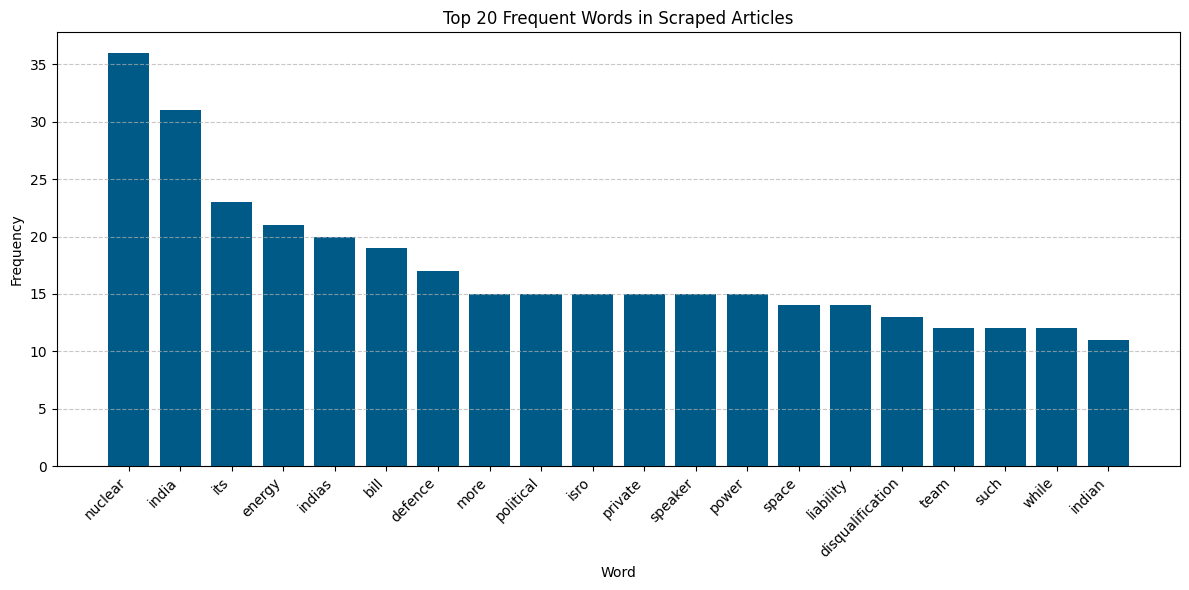

In [7]:
# Dashboard / Visualization
if not word_df.empty:
    plt.figure(figsize=(12, 6))
    plt.bar(word_df['Word'], word_df['Frequency'], color='#005a87')
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 20 Frequent Words in Scraped Articles')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No data to plot.")